# Predicting Tm with simple NLP and Protein Embeddings

### [Short description of protein embeddings](https://www.uniprot.org/help/embeddings)

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

In [3]:
train = pd.read_table('/kaggle/input/novozymes-enzyme-stability-prediction/train.csv',sep=',').dropna()
test = pd.read_table('/kaggle/input/novozymes-enzyme-stability-prediction/test.csv',sep=',')

In [4]:
train['prot_len'] = [len(p) for p in train.protein_sequence.tolist()]
test['prot_len'] = [len(p) for p in test.protein_sequence.tolist()]

In [5]:
def GetFastaFromDF(df,output):
    outfile = open(output,'w')
    for i in tqdm(range(len(df))):
        outfile.write('>'+str(df['seq_id'].tolist()[i])+'\n')
        outfile.write(df['protein_sequence'].tolist()[i]+'\n')
    outfile.close()
# GetFastaFromDF(train,'./Novozyme.Train.fasta')
# GetFastaFromDF(test,'./Novozyme.Test.fasta')

In [6]:
# To free occupied memory manually, for GPU usage.
def freemem():
    torch.cuda.empty_cache()
    gc.collect()

# Getting amino acid 

In [7]:
aa = ['A', 'R', 'N', 'D', 'C', 
      'Q', 'E', 'G', 'H', 'I', 
      'L', 'K', 'M', 'F', 'P', 
      'S', 'T', 'W', 'Y', 'V']


In [8]:
def aa_bow(sequence,aminolist):
    bow_in=[]
    for a in aminolist:
        bow_in.append(sequence.count(a))
    return(bow_in)

In [9]:
def get_bow(df):
    bow_lst=[]
    for i in range(len(df)):
        bow_tmp = aa_bow(df.protein_sequence.tolist()[i],aa)
        bow_lst.append(bow_tmp)
    bow_df = pd.DataFrame(bow_lst,columns = aa)
    return(bow_df)

In [10]:
train_df = pd.concat([get_bow(train),train],axis=1)
test_df = pd.concat([get_bow(test),test],axis=1)

- Protein sources are important for explaining batch effect or institutional bias

- So categorize them to use as a feature input

In [11]:
train_df["data_source"] = train_df["data_source"].astype('category')
train_df["data_source_cat"] = train_df["data_source"].cat.codes

test_df["data_source"] = test_df["data_source"].astype('category')
test_df["data_source_cat"] = test_df["data_source"].cat.codes


In [12]:
train_df = train_df.dropna()
train_df = train_df[train_df.prot_len<1000] # for the Protein embedding calculation

# Adding protein embedding features


### https://github.com/facebookresearch/esm
- Meta provides protein embedding models for various of sizes, including a model with 8M parameter, which is the smallest.
- We're gonna use the model trained by pytorch, and from the inference result of each protein sequence, 320 features will be extracted for the prediction of Thermostability.


In [13]:
import torch
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t6_8M_UR50D") # using relatively small model
model = model.cuda()


Downloading: "https://github.com/facebookresearch/esm/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


In [14]:
def GetDataForESM(df):
    result = [(df.seq_id.tolist()[i],df.protein_sequence.tolist()[i]) for i in range(len(df))]
    return(result)

In [15]:
train_dict = GetDataForESM(train_df)
test_dict = GetDataForESM(test_df)

In [16]:
def GetProteinRepresentation(data):
    batch_converter = alphabet.get_batch_converter()
    model.eval()  # disables dropout for deterministic results
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    with torch.no_grad():
        results = model(batch_tokens.cuda(), repr_layers=[6])
    token_representations = results["representations"][6]

    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))
    return(sequence_representations)

# Generate Embeddings for each proteins
- Need to chunk the dataset for the use of restricted GPU provide by Kaggle.

In [17]:
freemem()
test_embedding = []
for i in tqdm(range(0, len(test_dict), 50)):
    batch = test_dict[i:i+50]
    test_embedding.append(GetProteinRepresentation(batch))
    freemem()

100%|██████████| 49/49 [00:16<00:00,  2.93it/s]


In [18]:
freemem()
train_embedding = []
for i in tqdm(range(0, len(train_dict), 50)):
    batch = train_dict[i:i+50]
    train_embedding.append(GetProteinRepresentation(batch))    
    freemem()

100%|██████████| 455/455 [07:36<00:00,  1.00s/it]


In [19]:
test_embedding = [item for sublist in test_embedding for item in sublist]
train_embedding = [item for sublist in train_embedding for item in sublist]

In [20]:
train_input = train_df.drop(['protein_sequence','data_source','seq_id'],axis=1).dropna()
test_input = test_df.drop(['protein_sequence','data_source','seq_id'],axis=1)

In [21]:
train_input_eb = [pd.DataFrame(train_embedding[i].cpu().numpy()).T for i in range(len(train_embedding))]
train_input_eb = pd.concat(train_input_eb)


test_input_eb = [pd.DataFrame(test_embedding[i].cpu().numpy()).T for i in range(len(test_embedding))]
test_input_eb = pd.concat(test_input_eb)

In [22]:
train_input = pd.concat([train_input.reset_index(drop = True),train_input_eb.reset_index(drop = True)],axis=1)
test_input = pd.concat([test_input.reset_index(drop = True),test_input_eb.reset_index(drop = True)],axis=1)

In [23]:
# train_input.to_csv('train_clean.csv',sep=',',index = False)
# test_input.to_csv('test_clean.csv',sep=',',index = False)

# Training

In [24]:
import optuna
import sklearn
import sklearn.ensemble
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Define an objective function to be minimized.
def objective(trial):

    regressor_name = trial.suggest_categorical('classifier', ['RandomForest'])
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    regressor_obj = sklearn.ensemble.RandomForestRegressor(max_depth=rf_max_depth)

    X_train, X_val, y_train, y_val = train_test_split(train_input.drop('tm',axis=1),train_input['tm'])
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)

    regressor_obj.fit(X_train, y_train)
    y_pred = regressor_obj.predict(X_val)

    error = sklearn.metrics.mean_squared_error(y_val, y_pred)

    return error  # An objective value linked with the Trial object.

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=5)  # Invoke optimization of the objective function.

[I 2022-12-12 04:46:38,532] A new study created in memory with name: no-name-4a49e8f0-3a34-49db-96d8-db71423990ef
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dty

In [25]:
clf = study.best_trial.params['classifier']
best_model = sklearn.ensemble.RandomForestRegressor(max_depth = study.best_trial.params['rf_max_depth'])

In [26]:
X_train, X_val, y_train, y_val = train_test_split(train_input.drop('tm',axis=1),train_input['tm'])
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
best_model.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


RandomForestRegressor(max_depth=25)

# Correlation value for train dataset ( Train-test split )

In [27]:
from scipy import stats
corr_value = stats.pearsonr(y_val,best_model.predict(X_val))[0]
print(corr_value)

0.7747804621641007


# Submssion

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


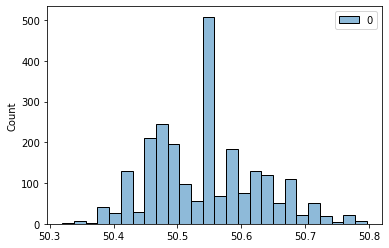

In [28]:
predicted_data = pd.DataFrame(best_model.predict(test_input))

sns.histplot(predicted_data)

predicted_data.index = test.seq_id
predicted_data.columns = ['tm']
predicted_data = predicted_data.reset_index()
predicted_data.to_csv('submission.csv',sep=',',index = False)